# Logistics Regression
---

## the data
 我们将建立一个逻辑回归模型来预测一个学生是否被大学录取，假设你是大学系的管理员，你想根据两次考试的结果来决定每个申请人的录取机会，你有以前的申请人的历史数据，你可以用它作为逻辑回归的训练集，对于每一个培训例子，你有两们考试的申请人的分数和录取觉得，为了做到这一点，我们将建立一个分类模型，根据考试成绩估计入学概率


In [95]:
# 三大件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [96]:
import os

path = 'data' + os.sep + 'LogiReg_data.txt'
print(path)
pdData = pd.read_csv(path,header=None,names=['Exam 1','Exam 2','Admitted'])
pdData.head()

data/LogiReg_data.txt


,Exam 1,Exam 2,Admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


In [97]:
pdData.shape

(100, 3)

Text(0,0.5,'Exam 2 score')

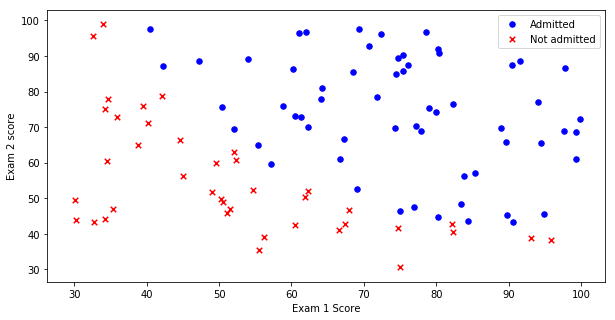

In [98]:
positive = pdData[pdData['Admitted'] == 1]
negative = pdData[pdData['Admitted'] == 0]

fig,ax = plt.subplots(figsize=(10,5))
ax.scatter(positive['Exam 1'],positive['Exam 2'],s=30,c='b',marker='o',label='Admitted')
ax.scatter(negative['Exam 1'],negative['Exam 2'],s=30,c='r',marker='x',label='Not admitted')
ax.legend()
ax.set_xlabel('Exam 1 Score')
ax.set_ylabel('Exam 2 score')


## The logistic regression
 目标：建立分类器，（求解出三个参数 $\theta_1,\theta_2,\theta_3$）
 
 设定阈值，根据阈值判断录取结果
 
 ### 要完成的模块
 - sigmod：映射到概率的函数
 - model：返回预测结果值
 - cost：目标函数
 - gradient：计算每个参数的梯度方向
 - descend：进行参数更新
 - accuracy：计算精度

#### sigmoid 函数   
### $g(Z) = \frac{1}{1+e^\left(-Z\right)}$

In [99]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

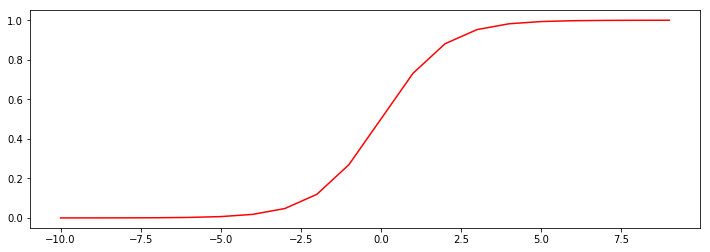

In [100]:
nums = np.arange(-10,10,step=1)
fig ,ax = plt.subplots(figsize=(12,4))
ax.plot(nums,sigmod(nums),c='r')

## Sigmod
- g:R-> [0,1]
- g(0) = 0.5
- g(-$\infty$) = 0
- g(+$\infty$) = 1

# model

In [101]:
def model(X,theta):
    return sigmoid(np.dot(X,theta.T))

$$(\theta_1,\theta_2,\theta_3) *\left(\begin {matrix} 1 \\x_1\\x_2 \end{matrix}\right) = \theta_0+\theta_1x1+\theta_2x2$$

In [102]:
pdData.insert(0,'Ones',1)

# 
orig_data = pdData.values
cols = orig_data.shape[1]
X = orig_data[:,0:cols-1]
y = orig_data[:,cols-1:cols]

theta = np.zeros([1,3])

In [103]:
X[:5]

array([[ 1.        , 34.62365962, 78.02469282],
       [ 1.        , 30.28671077, 43.89499752],
       [ 1.        , 35.84740877, 72.90219803],
       [ 1.        , 60.18259939, 86.3085521 ],
       [ 1.        , 79.03273605, 75.34437644]])

In [104]:
y[:5]

array([[0.],
       [0.],
       [0.],
       [1.],
       [1.]])

In [105]:
theta

array([[0., 0., 0.]])

In [106]:
X.shape,y.shape,theta.shape

((100, 3), (100, 1), (1, 3))

In [107]:
orig_data.shape

(100, 4)

### 损失函数
将对数似然函数去负号
### $$D(h_0(x),y) = -y\log(h_0(x)) - (1-y)\log(1-h_0(x))$$

求平均损失
### $$J(\theta) = \frac {1}{n} \sum_\left(i=1\right)^n\ D(h_0(x_i),y_i)$$

In [108]:
def cost(X,y,theta):
    left = np.multiply(-y,np.log(model(X,theta)))
    right = np.multiply(1-y,np.log(1- model(X,theta)))
    return np.sum(left-right)/len(X)

In [109]:
cost(X,y,theta)

0.6931471805599453

# 计算梯度

### $$\frac {\partial J}{\partial \theta_j} = - \frac {1}{m} \sum_{i=1}^m (y_i- h_0(x_i))x_{ij}$$

In [110]:
def gradient(X,y,theta):
    grad = np.zeros(theta.shape)
    error = (model(X,theta) - y).ravel()
    for j in range(len(theta.ravel())):
        term = np.multiply(error,X[:,j])
        grad[0,j] = np.sum(term)/len(X)
    return grad

# Gradient descent
比较三种不同的梯度下降方法

In [111]:
# 迭代次数
STOP_ITER = 0
# 损失函数的下降阈值
STOP_COST = 1
# 梯度变化率较
STOP_GRAD = 2

def stopCriterion(type,value,threshold):
#     设定三种不同的停止策略
    if type == STOP_ITER: return value > threshold
    elif type == STOP_COST: return abs(value[-1]- value[-2]) < threshold
    elif type == STOP_GRAD: return np.linalg.norm(value) < threshold

In [112]:
import numpy.random

def shuffleData(data):
    np.random.shuffle(data)
    cols = data.shape[1]
    X = data[:,0:cols-1]
    y = data[:,cols-1:]
    return X,y

In [113]:
import time
def descent(data,theta,batchSize,stoptype,thresh,alpha):
    init_time = time.time()

    i = 0  #迭代次数
    k= 0  #  batch
    X,y = shuffleData(data)
    
    grad = np.zeros(theta.shape) #计算的梯度
    costs = [cost(X,y,theta)]  #损失值
    
    while True:
        grad = gradient(X[k:k+batchSize],y[k:k+batchSize],theta)
        k += batchSize
        if k >= n:
            k = 0
            X,y = shuffleData(data)
        theta = theta - alpha*grad  #更新参数
        costs.append(cost(X,y,theta))
        i += 1
        if stoptype == STOP_ITER: value = i
        elif stoptype == STOP_COST: value = costs
        elif stoptype == STOP_GRAD: value = grad
        if stopCriterion(stoptype,value,threshold=thresh):break
    return theta,i-1,costs,time.time()-init_time


In [114]:
def runExpe(data,theta,batchSize,stopType,thresh,alpha):
    theta,iters,costs,duration = descent(data,theta,batchSize,stopType,thresh,alpha)
    
    name = "Original" if (data[:,1] > 2).sum() > 1 else "Scaled"
    name += 'data - learning rate:{}'.format(alpha)
    if batchSize == n:strDesctype = 'Gradient'
    elif batchSize == 1:strDesctype = 'Stochastic'
    else: strDesctype = 'Mini-batch ({})'.format(batchSize)
    
    name += strDesctype + 'descent - Stop'
    
    if stopType == STOP_ITER:strStop = "{} iterations".format(iters)
    elif stopType == STOP_COST:strStop = "cost change < {}".format(thresh)
    else: strStop = "gradient norm < {}".format(thresh)
    
    name += strStop
    
    print("***{} \ n Theta:{} - Iter:{} - Last cost:{:03.2f} - Duration:{}".format(name,theta,iters,costs[-1],duration))
    
    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot(np.arange(len(costs)),costs,'r')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Cost')
    ax.set_title(name.upper() + '- Error vs. Iteration')
    return theta

---
# 不同的停止策略
## 设定迭代次数

***Originaldata - learning rate:1e-06Gradientdescent - Stop5000 iterations \ n Theta:[[-0.00027127  0.00705232  0.00376711]] - Iter:5000 - Last cost:0.63 - Duration:0.8056950569152832


array([[-0.00027127,  0.00705232,  0.00376711]])

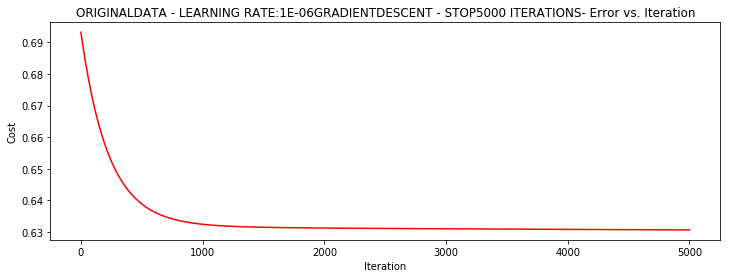

In [115]:
n = 100
runExpe(orig_data,theta,n,STOP_ITER,thresh=5000,alpha=0.000001)


## 根据损失值停止
### 设定阈值 1E6 ,差不多需要110000 次迭代

***Originaldata - learning rate:0.001Gradientdescent - Stopcost change < 1e-06 \ n Theta:[[-5.13364014  0.04771429  0.04072397]] - Iter:109901 - Last cost:0.38 - Duration:18.152911901474


array([[-5.13364014,  0.04771429,  0.04072397]])

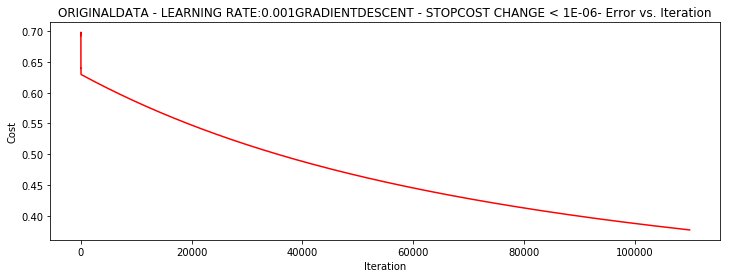

In [116]:
runExpe(orig_data,theta,n,STOP_COST,thresh=0.000001,alpha=0.001)

## 根据梯度变化停止
### 设定阈值 0.05，差不多需要40 000次迭代

***Originaldata - learning rate:0.001Gradientdescent - Stopgradient norm < 0.05 \ n Theta:[[-2.37033409  0.02721692  0.01899456]] - Iter:40045 - Last cost:0.49 - Duration:6.470273017883301


array([[-2.37033409,  0.02721692,  0.01899456]])

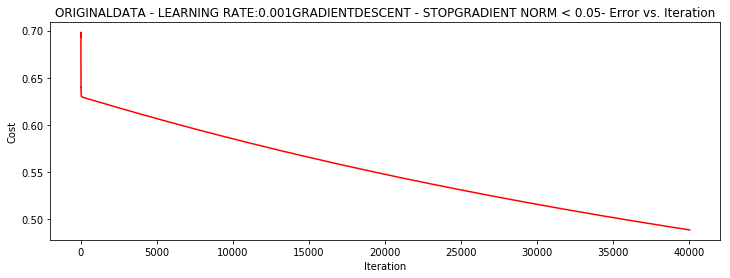

In [117]:
runExpe(orig_data,theta,n,STOP_GRAD,thresh=0.05,alpha=0.001)

---
## 对比不同梯度的下降方法
### Stochastic descent(随机梯度下降)

***Originaldata - learning rate:0.001Stochasticdescent - Stop5000 iterations \ n Theta:[[-0.38749904  0.11668734  0.0204849 ]] - Iter:5000 - Last cost:2.72 - Duration:0.2631039619445801


array([[-0.38749904,  0.11668734,  0.0204849 ]])

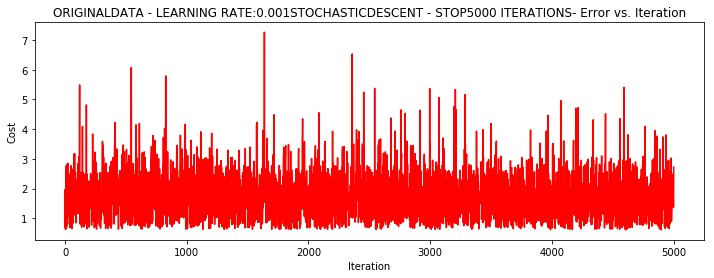

In [118]:
runExpe(orig_data,theta,1,STOP_ITER,thresh=5000,alpha=0.001)

损失函数的振幅很大，试着调小点学习率

***Originaldata - learning rate:1e-06Stochasticdescent - Stop5000 iterations \ n Theta:[[-0.0002707   0.00710642  0.00382253]] - Iter:5000 - Last cost:0.63 - Duration:0.26085591316223145


array([[-0.0002707 ,  0.00710642,  0.00382253]])

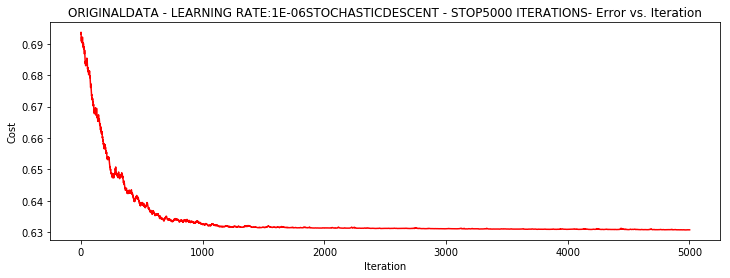

In [119]:
runExpe(orig_data,theta,1,STOP_ITER,5000,0.000001)

## Mini-batch

***Originaldata - learning rate:0.001Mini-batch (16)descent - Stop5000 iterations \ n Theta:[[-0.35703234  0.00351058  0.00563635]] - Iter:5000 - Last cost:0.63 - Duration:0.3358142375946045


array([[-0.35703234,  0.00351058,  0.00563635]])

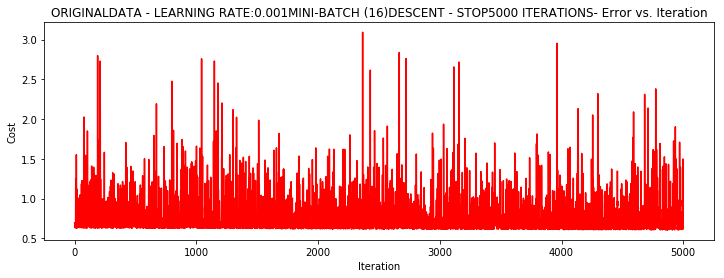

In [120]:
runExpe(orig_data,theta,16,STOP_ITER,5000,0.001)

浮动仍然很大，我们尝试对特征数据进行标准化，用Z-score处理之后的值来进行模型训练

***Scaleddata - learning rate:0.001Mini-batch (16)descent - Stop15000 iterations \ n Theta:[[0.5763392  1.56488487 1.41118829]] - Iter:15000 - Last cost:0.28 - Duration:1.1436212062835693


array([[0.5763392 , 1.56488487, 1.41118829]])

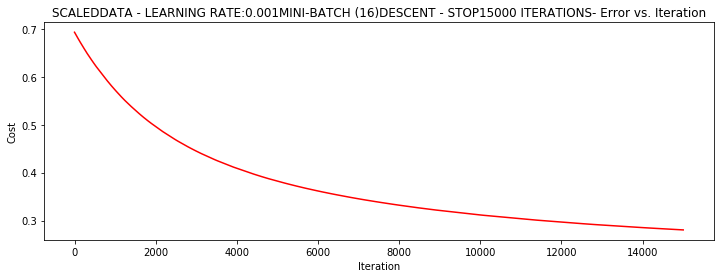

In [121]:
from sklearn import preprocessing

scaled_data = orig_data.copy()
scaled_data[:,1:3] = preprocessing.scale(orig_data[:,1:3])

runExpe(scaled_data,theta,16,STOP_ITER,15000,0.001)

这次取得了比较好的结果，损失函数能降到 0.3以下了，所以对数据进行预处理是很有必要的

再试一下其他的停止条件

***Scaleddata - learning rate:0.001Gradientdescent - Stopgradient norm < 0.02 \ n Theta:[[1.0707921  2.63030842 2.41079787]] - Iter:59422 - Last cost:0.22 - Duration:10.335807085037231


array([[1.0707921 , 2.63030842, 2.41079787]])

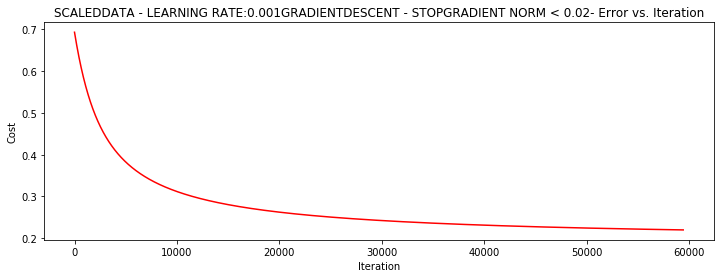

In [122]:
runExpe(scaled_data,theta,n,STOP_GRAD,thresh=0.02,alpha=0.001)

更多的迭代次数会使得损失下降的更多

***Scaleddata - learning rate:0.001Stochasticdescent - Stopgradient norm < 0.0004 \ n Theta:[[1.14776264 2.79228375 2.56631313]] - Iter:72588 - Last cost:0.22 - Duration:4.7581140995025635


array([[1.14776264, 2.79228375, 2.56631313]])

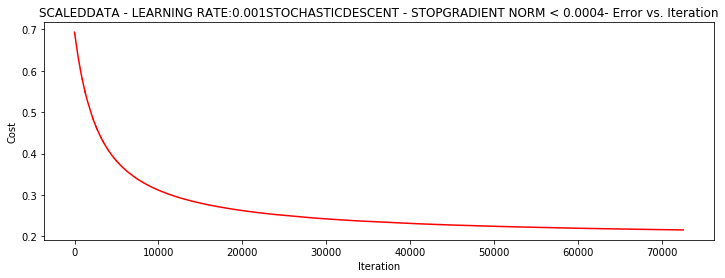

In [123]:
runExpe(scaled_data,theta,1,STOP_GRAD,thresh=0.002/5,alpha=0.001)

### 随机梯度下降的更快，但是需要的迭代的次数也增加了，所以还是 mini-batch更合理 !!!

***Scaleddata - learning rate:0.001Mini-batch (16)descent - Stopgradient norm < 0.004 \ n Theta:[[0.9420332  2.36961129 2.16503386]] - Iter:43167 - Last cost:0.23 - Duration:3.8404040336608887


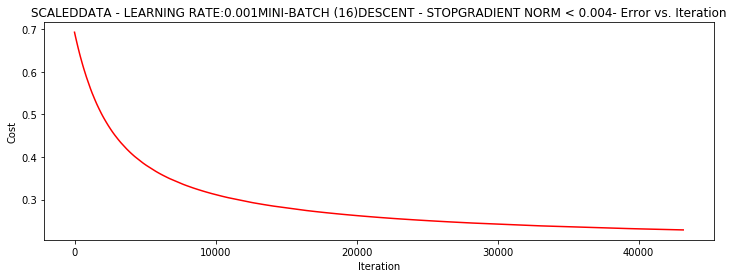

In [128]:
theta = runExpe(scaled_data,theta,16,STOP_GRAD,thresh=0.002*2,alpha=0.001)

## 精度

In [129]:
def predict(X,theta):
    return [1 if x >= 0.5 else 0 for x in model(X,theta)]

scaled_X = scaled_data[:,:3]
y = scaled_data[:,3]
predictions = predict(scaled_X,theta)
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a,b) in zip(predictions,y)]
accuracy = (sum(map(int,correct)) % len(correct))
print("accuracy = {0}".format(accuracy))
      


accuracy = 90
